In [1]:
import pandas as pd
import talib
import matplotlib.pyplot as plt

In [2]:
# Define file paths relative to the notebook
file_paths = {
    'AAPL': '../data/yfinance_data/AAPL.csv',
    'AMZN': '../data/yfinance_data/AMZN.csv',
    'GOOG': '../data/yfinance_data/GOOG.csv',
    'META': '../data/yfinance_data/META.csv',
    'MSFT': '../data/yfinance_data/MSFT.csv',
    'NVDA': '../data/yfinance_data/NVDA.csv'
}

### Merging the 7 csv files

In [3]:
def load_and_merge_data(file_paths):
    """
    Load and merge CSV files into a single DataFrame.
    """
    data_frames = []
    for company, file_path in file_paths.items():
        df = pd.read_csv(file_path)
        df['Company'] = company  # Add a column for the company name
        data_frames.append(df)

    merged_df = pd.concat(data_frames, ignore_index=True)
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'Company']
    if not all(col in merged_df.columns for col in required_columns):
        raise ValueError('Data does not contain the required columns')

    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    merged_df.set_index('Date', inplace=True)
    merged_df.sort_index(inplace=True)
    
    return merged_df

In [ ]:
def calculate_indicators(df):
    """
    Calculate technical indicators per company and add them to the DataFrame.
    Works on a merged DataFrame that contains a 'Company' column.
    """
    df = df.copy()
    # ensure Close is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    # initialize columns to preserve order and avoid KeyError
    for col in ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist']:
        if col not in df.columns:
            df[col] = pd.NA

    # compute indicators per company so that moving windows don't mix tickers
    for company, grp in df.groupby('Company', group_keys=False):
        grp = grp.sort_index()
        close = grp['Close']
        # talib functions accept numpy arrays; results align by index order
        sma20 = talib.SMA(close.values, timeperiod=20)
        sma50 = talib.SMA(close.values, timeperiod=50)
        rsi = talib.RSI(close.values, timeperiod=14)
        macd, macd_signal, macd_hist = talib.MACD(close.values, fastperiod=12, slowperiod=26, signalperiod=9)

        df.loc[grp.index, 'SMA_20'] = sma20
        df.loc[grp.index, 'SMA_50'] = sma50
        df.loc[grp.index, 'RSI'] = rsi
        df.loc[grp.index, 'MACD'] = macd
        df.loc[grp.index, 'MACD_signal'] = macd_signal
        df.loc[grp.index, 'MACD_hist'] = macd_hist

    return df

In [5]:
def plot_stock_data(df, company):
    """
    Plot stock data and technical indicators for a specific company.
    """
    company_df = df[df['Company'] == company]
    
    plt.figure(figsize=(14, 7))
    plt.plot(company_df['Close'], label='Close Price', color='blue')
    plt.plot(company_df['SMA_20'], label='SMA 20', color='red')
    plt.plot(company_df['SMA_50'], label='SMA 50', color='green')
    plt.title(f'{company} Stock Price and Moving Averages')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    plt.plot(company_df['RSI'], label='RSI', color='purple')
    plt.title(f'{company} Relative Strength Index (RSI)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    plt.plot(company_df['MACD'], label='MACD', color='blue')
    plt.plot(company_df['MACD_signal'], label='MACD Signal', color='red')
    plt.bar(company_df.index, company_df['MACD_hist'], label='MACD Histogram', color='grey', alpha=0.5)
    plt.title(f'{company} MACD and MACD Signal')
    plt.legend()
    plt.show()

In [6]:
merged_df = load_and_merge_data(file_paths)


In [7]:
merged_df.head()

,Close,High,Low,Open,Volume,Company
Date,,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL
2009-01-02,2.718000,2.726500,2.553500,2.567500,145928000,AMZN
2009-01-02,14.872976,14.924187,14.170662,14.287715,50084000,MSFT
2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,NVDA
2009-01-02,7.948608,7.960977,7.557264,7.633949,144961322,GOOG


In [15]:
merged_df = calculate_indicators(merged_df)

KeyError: 'SMA_20'

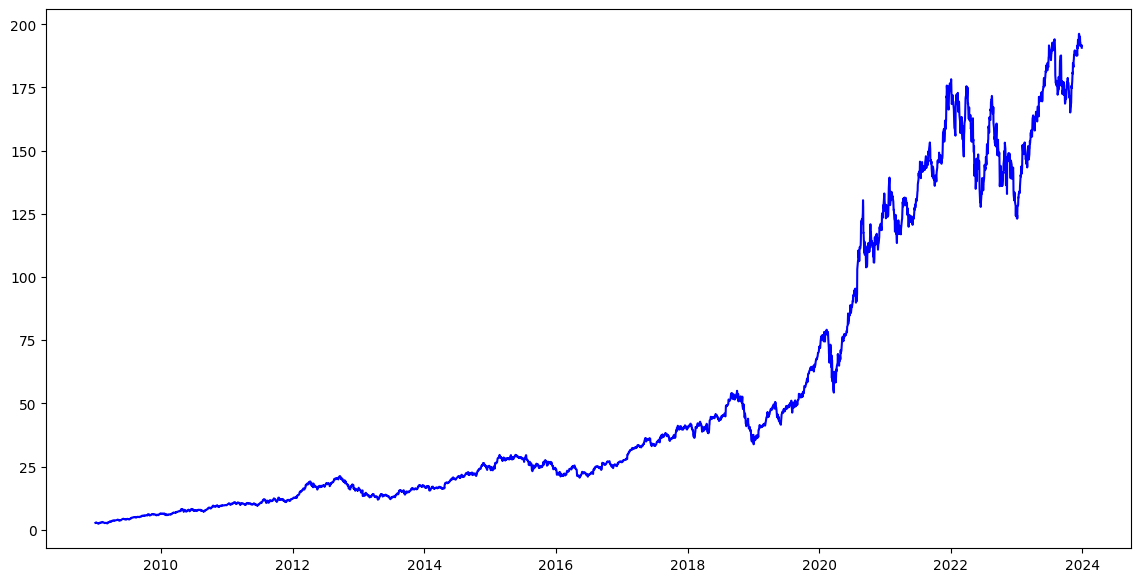

In [11]:
# Plot data for each company
for company in file_paths.keys():
    plot_stock_data(merged_df, company)